## Description
This project is based on the description of the hotel to recommend similar hotel

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
from icecream import ic
pd.options.display.max_columns =30

[nltk_data] Downloading package stopwords to C:\Users\Haipeng
[nltk_data]     Wang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Read file and data exploration

In [ ]:
df = pd.read_csv(r'Data\Seattle_Hotels.csv',encoding='latin-1')

In [14]:
ic(df.nunique())
df.head()

ic| df.nunique(): name       152
                  address    152
                  desc       152
                  dtype: int64


,name,address,desc
0,Hilton Garden Seattle Downtown,"1821 Boren Avenue, Seattle Washington 98101 USA","Located on the southern tip of Lake Union, the..."
1,Sheraton Grand Seattle,"1400 6th Avenue, Seattle, Washington 98101 USA","Located in the city's vibrant core, the Sherat..."
2,Crowne Plaza Seattle Downtown,"1113 6th Ave, Seattle, WA 98101","Located in the heart of downtown Seattle, the ..."
3,Kimpton Hotel Monaco Seattle,"1101 4th Ave, Seattle, WA98101",What?s near our hotel downtown Seattle locatio...
4,The Westin Seattle,"1900 5th Avenue, Seattle, Washington 98101 USA",Situated amid incredible shopping and iconic a...


In [20]:
df[df.index==1][['desc','name']].values[0]

array(["Located in the city's vibrant core, the Sheraton Grand Seattle provides a gateway to the diverse sights and sounds of the Pacific Northwest. Step out of our front doors to find gourmet dining and bars, world-class shopping, exciting entertainment, and iconic local attractions including the Pike Place Market, Space Needle and Chihuly Garden & Glass Museum. As one of only seven Sheraton hotels in North America to earn the esteemed Grand designation, guests can book confidently knowing they?re receiving the highest benchmark on product and service offerings available. Experience our recently completed multimillion-dollar transformation featuring all new guest rooms, an expanded Sheraton Club Lounge, and modern meeting & event spaces. Gather in our stylish new lobby and enjoy our private art collection featuring local artists while enjoying your favorite beverage from Starbucks. The Sheraton Grand features several dining options including Loulay Kitchen & Bar by James Beard award w

### Explore most popular words in desc

In [49]:
# get top K words of n-gram features in corpus
def get_top_k_words(corpus, n, k):
    '''
    n: n-gram features
    k: top k
    '''
    vec = CountVectorizer(ngram_range =(n,n), stop_words ='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    ic(bag_of_words.shape)
    # get frequency of the word
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    # sorted freq by desc
    words_freq = sorted(words_freq, key =lambda x:x[1], reverse = True)
    return words_freq[:k]

ic| bag_of_words.shape: (152, 2994)
ic| common_words: [('seattle', 533),
                   ('hotel', 295),
                   ('center', 151),
                   ('downtown', 133),
                   ('free', 123),
                   ('located', 108),
                   ('rooms', 106),
                   ('stay', 105),
                   ('place', 102),
                   ('airport', 99),
                   ('space', 97),
                   ('market', 97),
                   ('enjoy', 93),
                   ('pike', 90),
                   ('inn', 89),
                   ('business', 87),
                   ('just', 82),
                   ('city', 79),
                   ('room', 77),
                   ('breakfast', 68)]


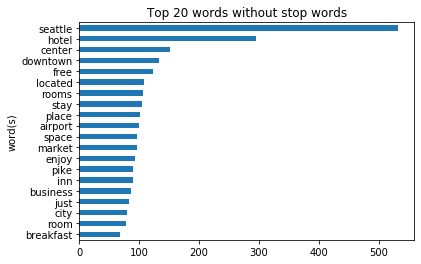

In [52]:
common_words = get_top_k_words(df['desc'],1,20)
ic(common_words)
# visulize by bar chart
df1 = pd.DataFrame(common_words, columns =['word(s)', 'count'])
df1.groupby('word(s)').sum()['count'].sort_values().plot(kind ='barh',
                                           title ='Top 20 words without stop words')
plt.show()

### Feature extraction
* using n-gram to extract n continuous words as feature
* using TF-IDF(min_df, max_df) to extract key word(s) and create TF-IDF matrix

In [67]:
# data cleansing
replaceBySpaceRE = re.compile('[/(){}\[\]\|@,;\\r\\n]')
example =df.iloc[0]['desc']
print(example)
replaceByspace=replaceBySpaceRE.sub('',df.iloc[0]['desc'])
print(replaceByspace)

Located on the southern tip of Lake Union, the Hilton Garden Inn Seattle Downtown hotel is perfectly located for business and leisure. 
The neighborhood is home to numerous major international companies including Amazon, Google and the Bill & Melinda Gates Foundation. A wealth of eclectic restaurants and bars make this area of Seattle one of the most sought out by locals and visitors. Our proximity to Lake Union allows visitors to take in some of the Pacific Northwest's majestic scenery and enjoy outdoor activities like kayaking and sailing. over 2,000 sq. ft. of versatile space and a complimentary business center. State-of-the-art A/V technology and our helpful staff will guarantee your conference, cocktail reception or wedding is a success. Refresh in the sparkling saltwater pool, or energize with the latest equipment in the 24-hour fitness center. Tastefully decorated and flooded with natural light, our guest rooms and suites offer everything you need to relax and stay productive. U

In [70]:
badSymbolsRE = re.compile('[^0-9a-z #+_]')
print(badSymbolsRE.sub('',replaceByspace.lower()))
print(badSymbolsRE.sub('',example.lower()))

located on the southern tip of lake union the hilton garden inn seattle downtown hotel is perfectly located for business and leisure the neighborhood is home to numerous major international companies including amazon google and the bill  melinda gates foundation a wealth of eclectic restaurants and bars make this area of seattle one of the most sought out by locals and visitors our proximity to lake union allows visitors to take in some of the pacific northwests majestic scenery and enjoy outdoor activities like kayaking and sailing over 2000 sq ft of versatile space and a complimentary business center stateoftheart av technology and our helpful staff will guarantee your conference cocktail reception or wedding is a success refresh in the sparkling saltwater pool or energize with the latest equipment in the 24hour fitness center tastefully decorated and flooded with natural light our guest rooms and suites offer everything you need to relax and stay productive unwind in the bar and enj

In [78]:
stopWords = set(stopwords.words('english'))

In [82]:
def clean_text(text):
    text = text.lower()
    text = badSymbolsRE.sub('',text)
    # remove stop words
    text = ' '.join(word for word in text.split() if word not in stopWords)
    return text

In [84]:
df['desc_clean'] = df['desc'].apply(clean_text)
df[['desc','desc_clean']].head()

,desc,desc_clean
0,"Located on the southern tip of Lake Union, the...",located southern tip lake union hilton garden ...
1,"Located in the city's vibrant core, the Sherat...",located citys vibrant core sheraton grand seat...
2,"Located in the heart of downtown Seattle, the ...",located heart downtown seattle awardwinning cr...
3,What?s near our hotel downtown Seattle locatio...,whats near hotel downtown seattle location bet...
4,Situated amid incredible shopping and iconic a...,situated amid incredible shopping iconic attra...


In [ ]:
# build the model, Tfidf in sklearn already cover n_gram feature
df.set_index('name',inplace = True)
tf = TfidfVectorizer(analyzer ='word',stop_words ='english',ngram_range=(1,3), min_df= 0.01)
tfidf_matrix =  tf.fit_transform(df['desc_clean'])

In [92]:
print(tf.get_feature_names()[:10])
ic(len(tf.get_feature_names()))
tfidf_matrix.shape

ic| len(tf.get_feature_names()): 3142


['10', '100', '100 nonsmoking', '10minute', '11', '12', '120', '1200', '15', '15 miles']


(152, 3142)

### Calculate the similarity

In [94]:
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
ic(cosine_similarity.shape)
print(cosine_similarity)

ic| cosine_similarity.shape: (152, 152)


[[1.         0.03970655 0.10844699 ... 0.0457341  0.01208517 0.02782307]
 [0.03970655 1.         0.06133417 ... 0.06148493 0.01509612 0.03721015]
 [0.10844699 0.06133417 1.         ... 0.09219382 0.04233599 0.05625399]
 ...
 [0.0457341  0.06148493 0.09219382 ... 1.         0.05794692 0.04160991]
 [0.01208517 0.01509612 0.04233599 ... 0.05794692 1.         0.01732767]
 [0.02782307 0.03721015 0.05625399 ... 0.04160991 0.01732767 1.        ]]


### Recommendation

In [97]:
# according to the cosine_similarity and hotel name to recommend the similar ones
indices = pd.Series(df.index)
name ='The Bacon Mansion Bed and Breakfast'
indices[indices ==name ]

116    The Bacon Mansion Bed and Breakfast
Name: name, dtype: object

In [107]:
def recommendations(name,n=10, cosine_similarity = cosine_similarity):
    recom = []
    idx = indices[indices == name].index[0]
    ic(idx)
    # descending sort the value of cosine_similarity 
    score_series =pd.Series(cosine_similarity[idx]).sort_values(ascending=False)
    # top n recommendation(exclud self)
    topNIndex = list(score_series.iloc[1:n+1].index)
    for i in topNIndex:
        recom.append(indices[i])
    return recom

In [110]:
recommendations(name ='Gaslight Inn', n= 5)

ic| idx: 131


['Shafer Baillie Mansion Bed & Breakfast',
 '11th Avenue Inn Bed and Breakfast',
 'The Bacon Mansion Bed and Breakfast',
 'Bed and Breakfast Inn Seattle',
 'Chittenden House Bed and Breakfast']

In [109]:
recommendations('Hilton Seattle Airport & Conference Center')

ic| idx: 49


['Embassy Suites by Hilton Seattle Tacoma International Airport',
 'DoubleTree by Hilton Hotel Seattle Airport',
 'Seattle Airport Marriott',
 'Motel 6 Seattle Sea-Tac Airport South',
 'Knights Inn Tukwila',
 'Four Points by Sheraton Downtown Seattle Center',
 'Hampton Inn Seattle/Southcenter',
 'Radisson Hotel Seattle Airport',
 'Home2 Suites by Hilton Seattle Airport',
 'Best Western Seattle Airport Hotel']